# Courses recommendation system
# II. Exploratory data analysis

This is the second part of the Udacity Data Science Nanodegree capstone project, which consists in the creation of a course recommendation system.

Once the data is cleaned, is time to perform an exploratory data analysis. I will search for patterns and trends in data and I will create visualizations for this data as well.

## 1  Import libraries

In [1]:
import numpy as np
import pandas as pd
from db_utils import connection
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline


## 2 Retrieve data

In this step I will retrieve the clean data from database.

Retrieve courses

In [116]:
courses_query = '''SELECT c.*, cat.name AS category_name FROM courses c 
                    JOIN categories cat ON c.category_id = cat.id'''

courses_df = pd.read_sql_query(courses_query, con=connection())

courses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16663 entries, 0 to 16662
Data columns (total 10 columns):
id                 16663 non-null object
title              16663 non-null object
description        16663 non-null object
center             16663 non-null object
avg_rating         10884 non-null float64
num_reviews        16663 non-null int64
weighted_rating    10884 non-null float64
number_of_leads    16663 non-null int64
category_id        16663 non-null int64
category_name      16663 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 1.3+ MB


Retrieve leads

In [117]:
leads_query = 'SELECT * FROM clean_leads ORDER BY created_on DESC'

leads_df = pd.read_sql_query(leads_query, con=connection())

leads_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37079 entries, 0 to 37078
Data columns (total 3 columns):
user_id       37079 non-null object
course_id     37079 non-null object
created_on    37079 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 869.1+ KB


Retrieve reviews

In [118]:
reviews_query = 'SELECT * FROM clean_reviews ORDER BY created_on DESC'

reviews_df = pd.read_sql_query(reviews_query, con=connection())

reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26945 entries, 0 to 26944
Data columns (total 4 columns):
user_id       26945 non-null object
course_id     26945 non-null object
rating        26945 non-null int64
created_on    26945 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 842.1+ KB


## 3 Exploratory Data Analysis
### 3.1 User data

**Unique users who rated courses**

In [197]:
unique_rating_users = reviews_df['user_id'].nunique()
unique_rating_users

24401

**Unique users who requested courses' information**

In [199]:
unique_requesters = leads_df['user_id'].nunique()
unique_requesters

26182

### 3.2 Top courses by number of leads generated

I want to know the courses that generate more leads. 

In [200]:
top_courses = courses_df.sort_values('number_of_leads', ascending=False).head(10)

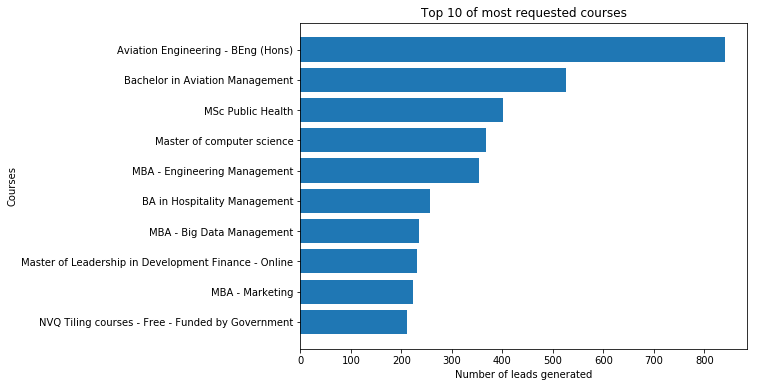

In [201]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(top_courses['title'], top_courses['number_of_leads'])
ax.set_title('Top 10 of most requested courses')
ax.set_xlabel('Number of leads generated')
ax.set_ylabel('Courses')
ax.invert_yaxis()
plt.show();

### 3.3 Top categories

Engineering courses seem to be the most requested, let's see the classification by categories.

In [202]:
top_requested_categories = courses_df.groupby('category_name').sum().sort_values('number_of_leads', ascending=False)['number_of_leads'].head(10)
courses_per_category = courses_df.groupby('category_name')['id'].count().sort_values(ascending=False).head(10)

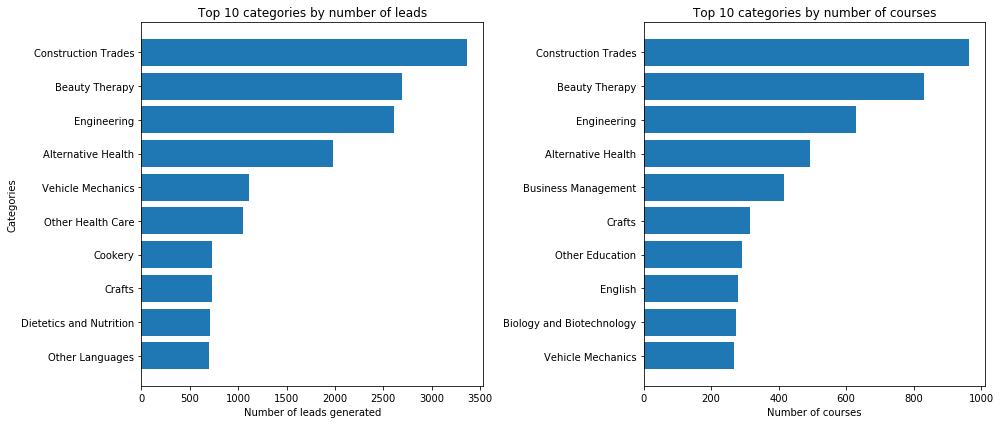

In [203]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

ax1.barh(top_requested_categories.index, top_requested_categories.values)
ax1.set_title('Top 10 categories by number of leads')
ax1.set_xlabel('Number of leads generated')
ax1.set_ylabel('Categories')
ax1.invert_yaxis()

ax2.barh(courses_per_category.index, courses_per_category.values)
ax2.set_title('Top 10 categories by number of courses')
ax2.set_xlabel('Number of courses')
ax2.invert_yaxis()

plt.tight_layout()
plt.show();

The most requested category is Construction Commerce while Engineering is the third most requested. This may be because these categories are also the first three by number of courses.

### 3.4 Number of users that requested information about a certain number of courses

It can be interesting to know how many leads each user generates. The following plot shows the number of users that generates a certain amount of leads.

In [204]:
user_requested_courses = leads_df.groupby('user_id')['course_id'].count().values

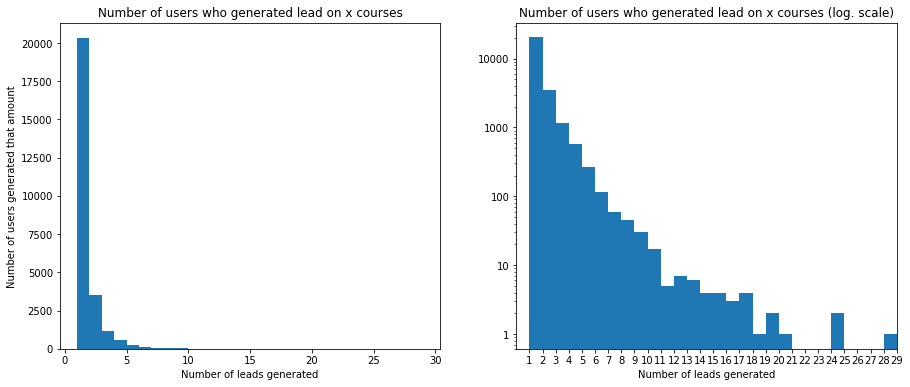

In [205]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

bins = np.arange(min(user_requested_courses), max(user_requested_courses) + 1)

ax1.hist(user_requested_courses, bins=bins)
ax1.set_title('Number of users who generated lead on x courses')
ax1.set_xlabel('Number of leads generated')
ax1.set_ylabel('Number of users generated that amount')

ax2.hist(user_requested_courses, bins=bins)
ax2.set_title('Number of users who generated lead on x courses (log. scale)')
ax2.set_xlabel('Number of leads generated')

ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())


plt.xlim(0, max(user_requested_courses))
plt.xticks(np.arange(min(user_requested_courses), max(user_requested_courses) + 1, 1.0))

plt.show();

**Number of users that requested information about a certain number of courses**

In [214]:
_, counts_elements = np.unique(user_requested_courses, return_counts=True)
users_requested_one = counts_elements[0]

users_requested_one

20313

**Percentage of users that requested information about one course**

In [215]:
users_requested_one / unique_requesters * 100

77.58383622335955

The trend is that the number of leads generated per user is very low. We note that most users only generate a lead. We can see the gap between the number of users that generates one lead (about 20,000 or 77.6% or unique users) and users that generates two or more (just over 2,500 users genrated two leads).

### 3.5 The most reviewed courses
Let's see the courses that more times have been rated.

In [106]:
top_reviewed_courses = courses_df.groupby('title').sum().sort_values('num_reviews', ascending=False).head(10)['num_reviews']

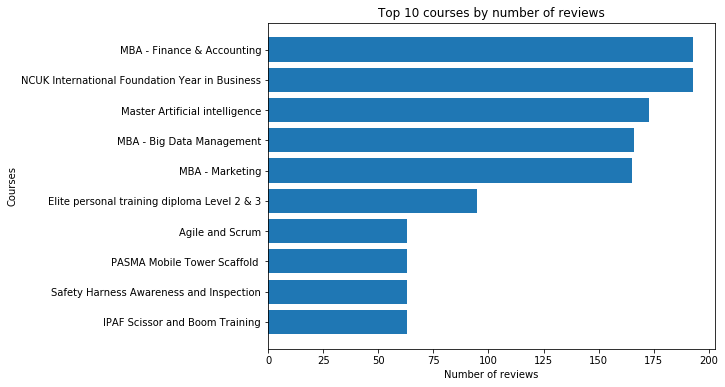

In [107]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(top_reviewed_courses.index, top_reviewed_courses.values)
ax.set_title('Top 10 courses by number of reviews')
ax.set_xlabel('Number of reviews')
ax.set_ylabel('Courses')
ax.invert_yaxis()
plt.show();

Finance-related and AI and big data courses on the top ten.

### 3.6 Rating average distribution
A good way to measure customer satisfaction is to see how users rate the courses.

In [114]:
courses_wr = courses_df[~courses_df['weighted_rating'].isnull()]['weighted_rating']
courses_wr.describe()

count    10884.000000
mean         7.766523
std          0.236055
min          5.269944
25%          7.679602
50%          7.809631
75%          7.839617
max          9.183618
Name: weighted_rating, dtype: float64

In [115]:
courses_wr.std()

0.23605541700495053

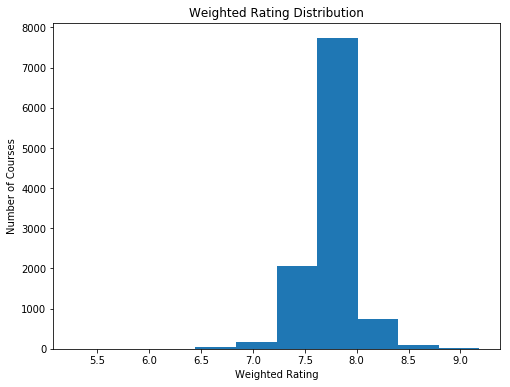

In [112]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(courses_wr)
ax.set_title('Weighted Rating Distribution')
ax.set_xlabel('Weighted Rating')
ax.set_ylabel('Number of Courses')

plt.show();

Users are satisfied with the training they receive, with an average rating of 7.7 and a median rating of 7.8 (standard deviation: 0.2).

### 3.7 Top courses by user's rating

In [120]:
top_rated_courses = courses_df.sort_values('weighted_rating', ascending=False).head(10)

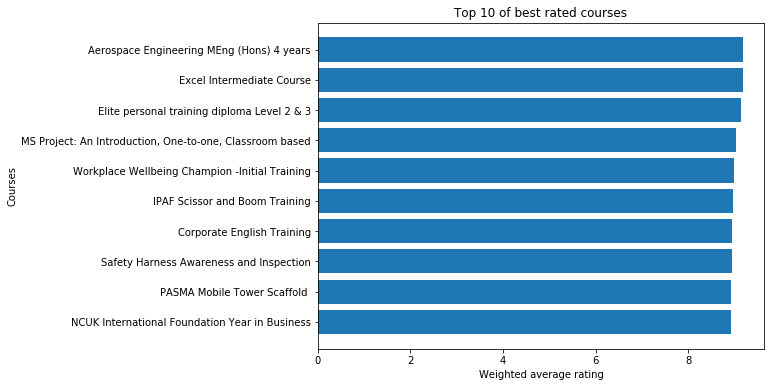

In [123]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(top_rated_courses['title'], top_rated_courses['weighted_rating'])
ax.set_title('Top 10 of best rated courses')
ax.set_xlabel('Weighted average rating')
ax.set_ylabel('Courses')
ax.invert_yaxis()
plt.show();

### 3.8 Top categories by user's ratings

In [140]:
top_rated_categories = courses_df.groupby('category_name')['weighted_rating'].mean().sort_values(ascending=False).head(10)
top_rated_categories

category_name
Medical Law                8.642718
Access                     8.087047
Applications               8.080864
Other Industrial Design    8.059925
HR Issues                  7.995338
Internet                   7.982531
Project Planning           7.944850
Martial Arts               7.942851
International Law          7.939034
Business Planning          7.936197
Name: weighted_rating, dtype: float64

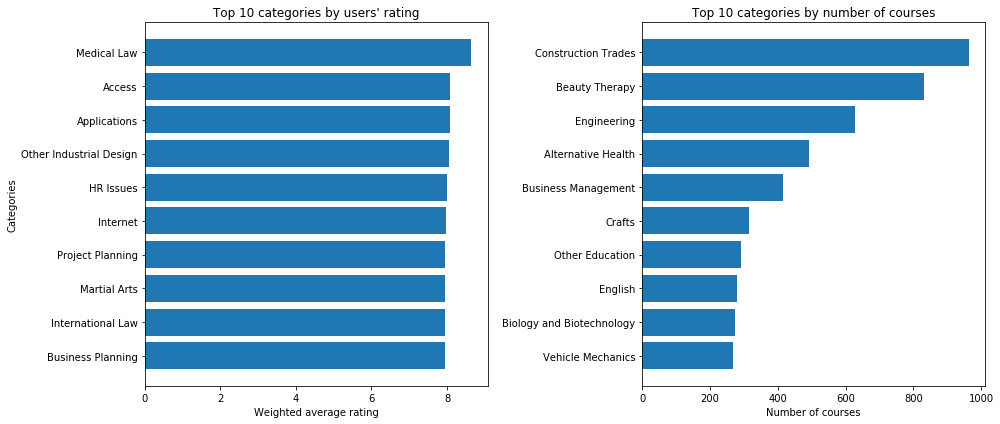

In [143]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

ax1.barh(top_rated_categories.index, top_rated_categories.values)
ax1.set_title('Top 10 categories by users\' rating')
ax1.set_xlabel('Weighted average rating')
ax1.set_ylabel('Categories')
ax1.invert_yaxis()

ax2.barh(courses_per_category.index, courses_per_category.values)
ax2.set_title('Top 10 categories by number of courses')
ax2.set_xlabel('Number of courses')
ax2.invert_yaxis()

plt.tight_layout()
plt.show();

The most valued category is medical law, but it isn't one of the categories with more courses.

### 3.9 Number of users that rates an amount of courses

It can be interesting to know how many leads each user generates. The following plot shows the number of users that generates a certain amount of leads.

In [176]:
user_rated_courses = reviews_df.groupby('user_id')['rating'].count().values

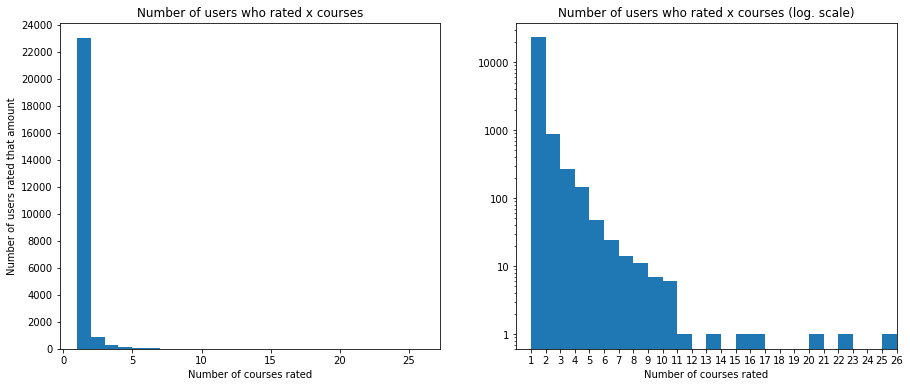

In [186]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

bins = np.arange(min(user_rated_courses), max(user_rated_courses) + 1)

ax1.hist(user_rated_courses, bins=bins)
ax1.set_title('Number of users who rated x courses')
ax1.set_xlabel('Number of courses rated')
ax1.set_ylabel('Number of users rated that amount')
ax1.set_yticks(range(0, 25001, 2000))

ax2.hist(user_rated_courses, bins=bins)
ax2.set_title('Number of users who rated x courses (log. scale)')
ax2.set_xlabel('Number of courses rated')

ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())


plt.xlim(0, max(user_rated_courses))
plt.xticks(np.arange(min(user_rated_courses), max(user_rated_courses) + 1, 1.0))

plt.show();

**Number of users rated a certain amount of courses**

In [211]:
_, counts_elements = np.unique(user_rated_courses, return_counts=True)
users_rated_one = counts_elements[0]

users_rated_one

22998

**Percentage of users that rated one course**

In [213]:
users_rated_one / unique_rating_users * 100

94.25023564608009

The pattern is similar to that seen in section 3.3, here, almost 23,000 users (94.25%) rate one course, but less than 2,000 rated two courses.

## 4 Conclusions
From the analysis performed above, the following conclusions can be drawn:

* The most requested courses are higher studies on engineerign-related areas.
* Most of the most requested categories are belong to technical areas.
* As expected, the more courses a category has, the more leads it will generate.
* The same cannot be said of ratings, best-rated categories do not have to be the ones with more courses.
* Users generate leads to a very small number of courses, which means that their interests are limited to very specific areas of knowledge. Also, most users are one-time customers.
* Same happens with ratings, most users rate a single course.